In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

(1) short rate simulation

In [2]:
# 1) Simulating S with variance reduction techniques
def EulerMCRates(parameters):
    np.random.seed(1000)

    # time setup
    #T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    r_0 = parameters['model']['r0']  # initial value
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value
    
    # simulation    
    r = np.zeros((numSteps + 1, numPaths),dtype=float)
    r[0,:] = r_0
  
    ################         simluations for short rate r(t)              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            Zs = np.random.normal(0, 1, 1)  
            
            if m_name == 'Vasicek':
                r[t_step,i] = r[t_step-1,i] + a*(b-r[t_step-1,i])*dt + sigma*np.sqrt(dt)*Zs # Vasicek model with Euler shceme
            elif m_name == 'CIR':
                r[t_step,i] = r[t_step-1,i] + a*(b-r[t_step-1,i])*dt + sigma*np.sqrt(r[t_step-1,i]*dt)*Zs # CIR model with Euler shceme
            
    return r


In [3]:
def EulerMCRates_Control(parameters):
    
    np.random.seed(1000)

    # time setup
    #T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    r_0 = parameters['model']['r0']  # initial value
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value
    
    # simulation    
    r_1 = np.zeros((numSteps + 1, numPaths),dtype=float)
    r_1[0,:] = r_0
    
    r_2 = np.zeros((numSteps + 1, numPaths),dtype=float)
    r_2[0,:] = r_0
  
    ################         simluations for short rate r(t)              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            Zs = np.random.normal(0, 1, 1)  
            Zs_minus = -Zs
            
            if m_name == 'Vasicek':            
                r_1[t_step,i] = r_1[t_step-1,i] + a*(b-r_1[t_step-1,i])*dt + sigma*np.sqrt(dt)*Zs # Vasicek model with Euler shceme
                r_2[t_step,i] = r_2[t_step-1,i] + a*(b-r_2[t_step-1,i])*dt + sigma*np.sqrt(dt)*Zs_minus # Vasicek model with Euler shceme
            elif m_name == 'CIR':
                r_1[t_step,i] = r_1[t_step-1,i] + a*(b-r_1[t_step-1,i])*dt + sigma*np.sqrt(r_1[t_step-1,i]*dt)*Zs # CIR model with Euler shceme
                r_2[t_step,i] = r_2[t_step-1,i] + a*(b-r_2[t_step-1,i])*dt + sigma*np.sqrt(r_2[t_step-1,i]*dt)*Zs_minus # CIR model with Euler shceme
            
    return r_1, r_2, (r_1+r_2)/2


In [4]:
if __name__=="__main__": # main function
    # initial value
    r0 = 0.02
    
    # model parameters
    # a*b>= sigma^2/2 to ensure positivity of short rates
    m_name = 'Vasicek'#'CIR' 
    a = 0.65
    b = 0.03
    sigma = 0.10        
    
    # discrete setup
    T = 0.5     # maturity
    N = 200  # steps
    dt = T/N
    M = 200
    
    parameters = {'model':{'r0':r0, 'a':a, 'b':b, 'sigma':sigma, 'name':m_name}, 
                  'setup':{'T':T, 'numSteps':N, 'dt': T/N, 'numPaths':M}                
                 }
    
    print(parameters['setup']['numSteps'])

200


In [6]:
# Task 1
# simulate short rate
Sim_r = EulerMCRates(parameters)
print(np.std(Sim_r[-1,:]))
    
[Sim_r1, Sim_r2, Sim_r3] = EulerMCRates_Control(parameters)
print(np.std(Sim_r1[-1,:]),np.std(Sim_r2[-1,:]), np.std(Sim_r3[-1,:]))

0.05828484752165961
0.05828484752165961 0.05828484752165962 3.124621755001402e-17


Text(0.5, 1.0, 'Standar Monte Carlo Simulation for Varsicek Model')

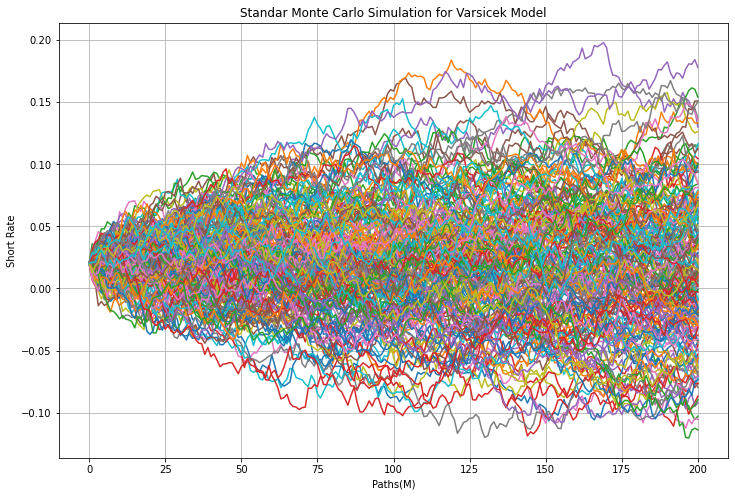

In [7]:
# standard MC
plt.figure(figsize=(12,8))
plt.plot(Sim_r)
plt.grid(True)
plt.xlabel('Paths(M)')
plt.ylabel('Short Rate')
plt.title('Standar Monte Carlo Simulation for Varsicek Model')

Text(0.5, 1.0, 'Standar Monte Carlo Simulation for Varsicek Model(control)')

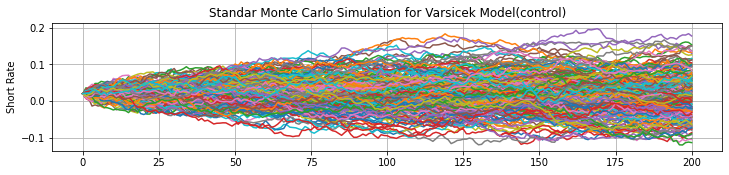

In [9]:
 # MC with control variates    
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(Sim_r1)
plt.grid(True)
plt.ylabel('Short Rate')
plt.title('Standar Monte Carlo Simulation for Varsicek Model(control)')

Text(0, 0.5, 'Short Rate')

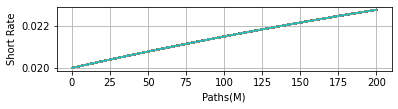

In [8]:
plt.subplot(3,1,3)
plt.plot(Sim_r3)
plt.grid(True)
plt.xlabel('Paths(M)')
plt.ylabel('Short Rate')

(2) bond option pring & term stucture

In [11]:
def MC_BondPriceYield(MC_short_rates, parameters):
    # Retrieve parameters for the short-rate model from dictionary "parameters"
    T_Maturity = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    r_0 = parameters['model']['r0']  # initial value
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value

    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

     # Construct A、B、Bond_Price
    A = np.zeros((numSteps+1,1))
    B = np.zeros((numSteps+1,1))
    Bond_Prices = np.zeros((numSteps+1, numPaths))
    Bond_Yields = np.zeros((numSteps+1, numPaths))
    for j in range(numSteps+1):  # in days
        tao_j = T_Maturity - j*dt  # in year
        
        if m_name == 'Vasicek':
            gamma = a**2*b - sigma**2/2
            B[j][0] = (1-np.exp(-a*tao_j))/a
            A[j][0] = (B[j][0]-tao_j)*gamma/a - sigma**2*B[j][0]**2/(4*a)            
        elif m_name == 'CIR':
            gamma = np.sqrt(a** 2 + 2 * sigma ** 2)            
            B[j][0] = 2 * (np.exp(gamma * tao_j) - 1) / (
                         (gamma + a) * (np.exp(gamma * tao_j) - 1) + 2 * gamma)
            A[j][0] = np.log(np.power(2 * gamma * np.exp((gamma + a) * tao_j / 2) / ((gamma + a) *
                               (np.exp(gamma * tao_j) - 1) + 2 * gamma), 2 * a *b / (sigma ** 2)))
            
            #print('A=%f, B=%f, gamma=%f'%(A[j][0],B[j][0],gamma))
        
        for i in range(numPaths):
            Bond_Prices[j][i] = np.exp(A[j][0] - B[j][0] * MC_short_rates[j][i])  # np.exp(A-B*r)  
            
            if tao_j > 0:
                Bond_Yields[j][i] = -np.log(Bond_Prices[j][i])/tao_j  # -(A[j][0] - B[j][0] * MC_short_rates[j][i])/tao_j  # np.exp(A-B*r)
            else:
                Bond_Yields[j][i] = MC_short_rates[j][i]  # equal to spot rate at t=T
                

    return Bond_Prices,Bond_Yields 

In [12]:
def MC_BondPriceYield(MC_short_rates, parameters):
    # Retrieve parameters for the short-rate model from dictionary "parameters"
    T_Maturity = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    r_0 = parameters['model']['r0']  # initial value
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value

    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

     # Construct A、B、Bond_Price
    A = np.zeros((numSteps+1,1))
    B = np.zeros((numSteps+1,1))
    Bond_Prices = np.zeros((numSteps+1, numPaths))
    Bond_Yields = np.zeros((numSteps+1, numPaths))
    for j in range(numSteps+1):  # in days
        tao_j = T_Maturity - j*dt  # in year
        
        if m_name == 'Vasicek':
            gamma = a**2*b - sigma**2/2
            B[j][0] = (1-np.exp(-a*tao_j))/a
            A[j][0] = (B[j][0]-tao_j)*gamma/a - sigma**2*B[j][0]**2/(4*a)            
        elif m_name == 'CIR':
            gamma = np.sqrt(a** 2 + 2 * sigma ** 2)            
            B[j][0] = 2 * (np.exp(gamma * tao_j) - 1) / (
                         (gamma + a) * (np.exp(gamma * tao_j) - 1) + 2 * gamma)
            A[j][0] = np.log(np.power(2 * gamma * np.exp((gamma + a) * tao_j / 2) / ((gamma + a) *
                               (np.exp(gamma * tao_j) - 1) + 2 * gamma), 2 * a *b / (sigma ** 2)))
            
            #print('A=%f, B=%f, gamma=%f'%(A[j][0],B[j][0],gamma))
        
        for i in range(numPaths):
            Bond_Prices[j][i] = np.exp(A[j][0] - B[j][0] * MC_short_rates[j][i])  # np.exp(A-B*r)  
            
            if tao_j > 0:
                Bond_Yields[j][i] = -np.log(Bond_Prices[j][i])/tao_j  # -(A[j][0] - B[j][0] * MC_short_rates[j][i])/tao_j  # np.exp(A-B*r)
            else:
                Bond_Yields[j][i] = MC_short_rates[j][i]  # equal to spot rate at t=T
                

    return Bond_Prices,Bond_Yields 

In [13]:
def TermStructure_Giventime(Rates_time_t, T_Maturity, parameters):
    
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value

    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']
    
    n = len(T_Maturity)
    num_t = len(Rates_time_t)

    TS_yields = np.zeros((num_t, n))

    for t  in range(num_t):
        r_t = Rates_time_t[t]
        for T_i in T_Maturity:  # range(1,size(T))
            if T_i == 0:
                TS_yields[t][0] = r_t
            else:
                tao_j = T_i  # in year
                
                if m_name == 'Vasicek':
                    gamma = a**2*b - sigma**2/2
                    B = (1-np.exp(-a*tao_j))/a
                    A = (B-tao_j)*gamma/a - sigma**2*B**2/(4*a)            
                elif m_name == 'CIR':
                    gamma = np.sqrt(a** 2 + 2 * sigma ** 2)            
                    B = 2 * (np.exp(gamma * tao_j) - 1) / (
                                 (gamma + a) * (np.exp(gamma * tao_j) - 1) + 2 * gamma)
                    A = np.log(np.power(2 * gamma * np.exp((gamma + a) * tao_j / 2) / ((gamma + a) *
                                       (np.exp(gamma * tao_j) - 1) + 2 * gamma), 2 * a *b / (sigma ** 2)))
                
                TS_yields[t][T_Maturity.index(T_i)] = -(A - B * r_t) / tao_j
    
    return TS_yields
    

In [14]:
# main function
if __name__ == '__main__':

    # initial value
    r0 = 0.02
    
    # model parameters
    # a*b>= sigma^2/2 to ensure positivity of short rates
    m_name = 'CIR'  #'Vasicek'
    a = 0.65
    b = 0.03
    sigma = 0.10        
    
    # discrete setup
    T = 1     # maturity
    N = 100  # steps
    dt = T/N
    M = 100
    
    parameters = {'model':{'r0':r0, 'a':a, 'b':b, 'sigma':sigma, 'name':m_name}, 
                  'setup':{'T':T, 'numSteps':N, 'dt': T/N, 'numPaths':M}                
                 }
    
    #       Conduct a standard Monte Carlo simulation for Vasicek Model and CIR model
    MC_short_rates = EulerMCRates(parameters)  # Steps X Paths
    #print(MC_short_rates)
    rs_df = pd.DataFrame(MC_short_rates)
    rs_df.to_csv("MC_short_rates.csv")
    
    #       Estimate the dynamics of bond prices over time with simulated rate paths
    #       Estimate the dynamics of yields over time with simulated rate paths
    [MC_bond_prices, MC_bond_yields] = MC_BondPriceYield(MC_short_rates, parameters)
    #print(MC_bond_yields)
    rs_df = pd.DataFrame(MC_bond_yields)
    rs_df.to_csv("MC_bond_yields.csv")
    
    #       Estimate the term structure of yileds at time 0<t<T, given T=[0.5, 1, 3, 5, 10, 15, 20, 25, 30]    
    Terms = ['0', '0.5', '1', '3', '5', '10', '15', '20', '25', '30']
    T_Maturity = list(map(float, Terms))
    N_t = 50
    
    Rates_t = np.transpose(MC_short_rates)[:,N_t]   # now Paths x Steps
    #print(Rates_t)
    TS_yields = TermStructure_Giventime(Rates_t, T_Maturity, parameters)
    #print(TS_yields)
    
    rs_df = pd.DataFrame(TS_yields)
    rs_df.to_csv("simulated_TS.csv")

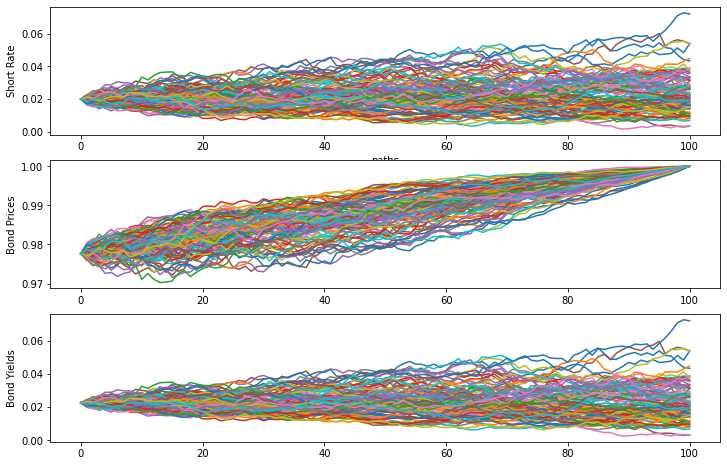

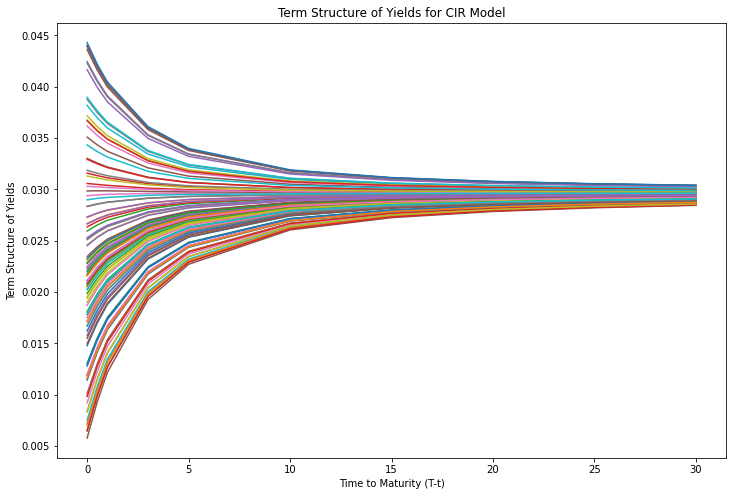

In [16]:
   #====================================================
    # Plot all results related to short-rate model specification
plt.figure(figsize=(12, 8))
plt.title('Short-Rates, Bond Prices and Yields for CIR Model')
plt.subplot(3, 1, 1)
plt.plot(MC_short_rates)  # times X paths
plt.xlabel('paths')
plt.ylabel('Short Rate')   

plt.subplot(3, 1, 2)
plt.plot(MC_bond_prices)  # times X paths
plt.ylabel('Bond Prices')
    
plt.subplot(3, 1, 3)
plt.plot(MC_bond_yields)  # times X paths
plt.ylabel('Bond Yields')
plt.show()
    
plt.figure(figsize=(12, 8))
    #plt.plot(T_Maturity,TS_yields)
plt.plot(T_Maturity, np.transpose(TS_yields))

plt.xlabel('Time to Maturity (T-t)')
plt.ylabel('Term Structure of Yields')
plt.title('Term Structure of Yields for CIR Model')

plt.show()

In [17]:
#PART III: valuation of bond option

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

def BondPrice(rates_t, Tau, parameters):
    # model parameters
    m_name = parameters['model']['name']
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value
    
    n = len(rates_t)
    Bond_Prices = np.zeros((n,1))
    
    for j in range(n):  # in days
        r_j = rates_t[j]  # in year
        
        if m_name == 'Vasicek':
            gamma = a**2*b - sigma**2/2
            B = (1-np.exp(-a*Tau))/a
            A = (B-Tau)*gamma/a - sigma**2*B**2/(4*a)            
        elif m_name == 'CIR':
            gamma = np.sqrt(a** 2 + 2 * sigma ** 2)            
            B = 2 * (np.exp(gamma * Tau) - 1) / (
                         (gamma + a) * (np.exp(gamma * Tau) - 1) + 2 * gamma)
            A = np.log(np.power(2 * gamma * np.exp((gamma + a) * Tau / 2) / ((gamma + a) *
                               (np.exp(gamma * Tau) - 1) + 2 * gamma), 2 * a *b / (sigma ** 2)))
            
        Bond_Prices[j] = np.exp(A - B * r_j)  # np.exp(A-B*r)
                
    return Bond_Prices
                

def BondOption_Price_BS(parameters):

    # model parameters
    r_0 = parameters['model']['r0']  # initial value
    
    m_name = parameters['model']['name']
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value 
    
    L = parameters['bond']['L']
    s = parameters['bond']['s']
    
    K = parameters['option']['K']    
    T = parameters['option']['T']    
    option_type = parameters['option']['optype'] 
    
    if m_name == 'Vasicek':
    
        P_0_s = BondPrice(np.asarray([r0]), s, parameters)
        P_0_T = BondPrice(np.asarray([r0]), T, parameters)        
        
        sigma_p = (sigma/a)*(1-np.exp(-a*(s-T)))*np.sqrt((1-np.exp(-2*a*T))/(2*a)) 
        h = (1/sigma_p)*np.log(L*P_0_s/(P_0_T*K)) + sigma_p/2
        
        d1 = h
        d2 = h - sigma_p
        
        if option_type == 1:  # call
            option_price = L*P_0_s* norm.cdf(d1) - K * P_0_T * norm.cdf(d2)
        elif option_type == -1: # put
            option_price = K * P_0_T * norm.cdf(-d2) - L*P_0_s* norm.cdf(-d1) 
    
    return option_price

def EulerMCRates(parameters):
    np.random.seed(1000)

    # time setup
    #T = parameters['setup']['T']  # total time/maturity
    numSteps = parameters['setup']['numSteps']  # number of steps
    numPaths = parameters['setup']['numPaths']  # number of simulated paths
    dt = parameters['setup']['dt']

    # model parameters
    m_name = parameters['model']['name']
    r_0 = parameters['model']['r0']  # initial value
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value
    
    # simulation    
    r = np.zeros((numSteps + 1, numPaths),dtype=float)
    r[0,:] = r_0
  
    ################         simluations for short rate r(t)              ########
    for i in range(numPaths):
        for t_step in range(1, numSteps+1):
            Zs = np.random.normal(0, 1, 1)  
            
            if m_name == 'Vasicek':
                r[t_step,i] = r[t_step-1,i] + a*(b-r[t_step-1,i])*dt + sigma*np.sqrt(dt)*Zs # Vasicek model with Euler shceme
            elif m_name == 'CIR':
                r[t_step,i] = r[t_step-1,i] + a*(b-r[t_step-1,i])*dt + sigma*np.sqrt(r[t_step-1,i]*dt)*Zs # CIR model with Euler shceme
            
    return r

def MC_bond_option_price(Rate_T, parameters):

    # model parameters
    r_0 = parameters['model']['r0']  # initial value
    
    m_name = parameters['model']['name']
    a = parameters['model']['a']
    b = parameters['model']['b']
    sigma = parameters['model']['sigma']  # initial value 
    
    L = parameters['bond']['L']
    s = parameters['bond']['s']
    
    K = parameters['option']['K']    
    T = parameters['option']['T']    
    option_type = parameters['option']['optype'] 
    
    numPaths = parameters['setup']['numPaths']
    
    if m_name == 'Vasicek':
        P_0 = BondPrice(np.asarray([r0]), T, parameters)
        
        P_T_s = BondPrice(Rate_T, s-T, parameters)
        payoffs = np.maximum(0, (P_T_s- K) if option_type == 1 else (K-P_T_s))
    
    MC_optionprice = P_0*(np.sum(payoffs)/numPaths)
    
    return MC_optionprice

if __name__=="__main__": # main function
    
    r0 = 0.02
    
    # model parameters
    # a*b>= sigma^2/2 to ensure positivity of short rates
    m_name = 'Vasicek'  #''CIR'
    a = 0.65
    b = 0.03
    sigma = 0.10    
    
    L = 1     # principal
    s = 2     # bond maturity
    
    K = 0.50
    T = 1     # option maturity    
    Optype = 1 # 1: call -1: put 
    
    # discrete setup    
    N = 100  # steps
    dt = T/N
    M = 200
    
    parameters = {'model':{'r0':r0, 'a':a, 'b':b, 'sigma':sigma,'name':m_name},                 
                  'option':{'K':K, 'optype': Optype, 'T':T},
                  'bond':{'L':L, 's':s},
                  'setup':{'T_sim':s, 'numSteps':N, 'dt': s/N, 'numPaths':M}                
                 }
    
    # analytical solutions using BS Formula
    BS_option_prices = BondOption_Price_BS(parameters)
   # print(BS_option_prices)
    
    #  MC for short-rate in Vasicek Model
    MC_short_rates = EulerMCRates(parameters)  # Steps X Paths    
    Option_t_n = int(parameters['option']['T']/parameters['setup']['dt'])
    #print(Option_t_n)
    MC_option_prices =  MC_bond_option_price(MC_short_rates[Option_t_n,:], parameters)
    
    print('BS_price=%f, MC_price=%f in Vasicek Model'%(BS_option_prices,MC_option_prices))
     


BS_price=0.472954, MC_price=0.471506 in Vasicek Model
